# Описание проекта
Подготовка прототипа модели машинного обучения для золотодобывающей компании.
Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.


## План выполнения работы:
### <a href=#1>1. Подготовка данных</a>
   #### <a href=#1_1> 1.1 Изучение данных</a>
   #### <a href=#1_2> 1.2 Проверка правильности рассчётов эффективности обогащения</a>
   #### <a href=#1_3> 1.3 Анализ признаков</a>
   #### <a href=#1_4> 1.4 Предобаботка данных</a>
### <a href=#2>2. Анализ данных</a>
   #### <a href=#2_1> 2.1 Анализ концентрации металлов (Au, Ag, Pb) на различных этапах очистки</a>
   #### <a href=#2_2> 2.2 Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках.</a>
   #### <a href=#2_3> 2.3 Исследование суммарной концентрацию всех веществ на разных стадиях</a>
### <a href=#3>3. Модель</a>
   #### <a href=#3_1> 3.1 Функция для вычисления итоговой sMAPE</a>
   #### <a href=#3_2> 3.2 Обучение и оценка качества моделей</a>


# <a id='1'> 1. Подготовка данных</a> 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, KFold, cross_val_score
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from sklearn import metrics
from scipy import stats as st


## <a id='1_1'> 1.1 Изучение данных</a> 

In [3]:
gold_recovery_train = pd.read_csv(r'c:\Users\hd\Documents\Python code\practikum\gold_zyfra\gold_recovery_train.csv', index_col='date')
gold_recovery_test = pd.read_csv(r'c:\Users\hd\Documents\Python code\practikum\gold_zyfra\gold_recovery_test.csv', index_col='date')
gold_recovery_full = pd.read_csv(r'c:\Users\hd\Documents\Python code\practikum\gold_zyfra\gold_recovery_full.csv', index_col='date')

In [4]:
datas = {'gold_recovery_train':gold_recovery_train, 
         'gold_recovery_test':gold_recovery_test, 
         'gold_recovery_full':gold_recovery_full}

In [5]:
#for key in datas.keys():
#    print('Содержание тaблицы '+key)
#    display(datas[key].head())

Информация о признаках в каждой из таблиц:

In [6]:
#for key in datas.keys():
#    print('Информация о таблице '+key)
#    display(datas[key].info())

Информация о пропусках в каждой из таблиц:

In [7]:
def percent_nan(data):
    isna_data = pd.DataFrame(data.isna().sum())
    isna_data.columns = ['nan']
    isna_data['rate'] = isna_data['nan']/len(data)
    return(isna_data.style.format("{:.2%}", subset='rate'))

In [8]:
#for key in datas.keys():
#    print('Информация о пропусках в таблице '+key)
#    display(percent_nan(datas[key]))

**Вывод:**
- Целевые признаки содержатся в столбцах `final.output.recovery` и `rougher.output.recovery` в таблицах ***gold_recovery_train*** и ***gold_recovery_full***. 
- В целевых признаках присутствуют пропуски до 15% в таблице с обучающей выборкой.
- В признаках так же присутствуют пропуски. 
- В таблице с тестовыми данными отсутсвуют некоторые признаки из таблицы с обучающей выборкой.

## <a id='1_2'> 1.2 Проверка правильности рассчётов эффективности обогащения</a> 

Рассчитаем эффективность обогощения чернового концентрата и финального концентрата по данным обучающей выборки.
Необходимые для расчёта параметры содержатся в столбцах:
- `rougher.input.feed_au`
- `rougher.output.tail_au`
- `rougher.output.concentrate_au`
- `final.output.tail_au`
- `final.output.concentrate_au`


In [9]:
rougher_recovery = gold_recovery_train.loc[:,['rougher.input.feed_au', 'rougher.output.tail_au', 
                                              'rougher.output.concentrate_au', 'rougher.output.recovery']]

In [10]:
final_recovery = gold_recovery_train.loc[:,['rougher.input.feed_au', 'final.output.tail_au', 
                                            'final.output.concentrate_au', 'final.output.recovery']]

In [11]:
def get_recovery(data):
    columns = data.columns
    data['recovery'] = (100*(data[columns[2]]*(data[columns[0]]-data[columns[1]]))/
                        (data[columns[0]]*(data[columns[2]]-data[columns[1]])))

In [12]:
get_recovery(rougher_recovery)
rougher_recovery.head()

,rougher.input.feed_au,rougher.output.tail_au,rougher.output.concentrate_au,rougher.output.recovery,recovery
date,,,,,
2016-01-15 00:00:00,6.486150,1.170244,19.793808,87.107763,87.107763
2016-01-15 01:00:00,6.478583,1.184827,20.050975,86.843261,86.843261
2016-01-15 02:00:00,6.362222,1.162562,19.737170,86.842308,86.842308
2016-01-15 03:00:00,6.118189,1.079755,19.320810,87.226430,87.226430
2016-01-15 04:00:00,5.663707,1.012642,19.216101,86.688794,86.688794


In [13]:
get_recovery(final_recovery)
final_recovery.head()

,rougher.input.feed_au,final.output.tail_au,final.output.concentrate_au,final.output.recovery,recovery
date,,,,,
2016-01-15 00:00:00,6.486150,2.143149,42.192020,70.541216,70.541216
2016-01-15 01:00:00,6.478583,2.224930,42.701629,69.266198,69.266198
2016-01-15 02:00:00,6.362222,2.257889,42.657501,68.116445,68.116445
2016-01-15 03:00:00,6.118189,2.146849,42.689819,68.347543,68.347543
2016-01-15 04:00:00,5.663707,2.055292,42.774141,66.927016,66.927016


Рассчитаем MAE между рассчитаным значением признака и указаным в таблице.

In [14]:
rougher_recovery = rougher_recovery.dropna(subset=['rougher.output.recovery', 'recovery'])
rougher_mae = metrics.mean_absolute_error(rougher_recovery['rougher.output.recovery'], 
                                          rougher_recovery['recovery'])
print('MAE эффективности обогащения чернового концентраты:', rougher_mae)

MAE эффективности обогащения чернового концентраты: 1.0898633667227423e-14


In [15]:
final_recovery = final_recovery.dropna(subset=['final.output.recovery', 'recovery'])
final_mae = metrics.mean_absolute_error(final_recovery['final.output.recovery'], 
                                        final_recovery['recovery'])
print('MAE эффективности обогащения финального концентраты:', final_mae)

MAE эффективности обогащения финального концентраты: 9.234385318911162e-15


**Вывод:**

Средняя абсолютная ошибка вычисления целевых признаков по формуле очень маленькая.

## <a id='1_3'> 1.3 Анализ признаков</a> 

In [16]:
print('Признаки, отсутствующие в тестовой выборке')
absent_feature = []
for column in gold_recovery_train.columns:
    if column not in gold_recovery_test.columns:
        absent_feature.append(column)
        print (column)

Признаки, отсутствующие в тестовой выборке
final.output.concentrate_ag
final.output.concentrate_pb
final.output.concentrate_sol
final.output.concentrate_au
final.output.recovery
final.output.tail_ag
final.output.tail_pb
final.output.tail_sol
final.output.tail_au
primary_cleaner.output.concentrate_ag
primary_cleaner.output.concentrate_pb
primary_cleaner.output.concentrate_sol
primary_cleaner.output.concentrate_au
primary_cleaner.output.tail_ag
primary_cleaner.output.tail_pb
primary_cleaner.output.tail_sol
primary_cleaner.output.tail_au
rougher.calculation.sulfate_to_au_concentrate
rougher.calculation.floatbank10_sulfate_to_au_feed
rougher.calculation.floatbank11_sulfate_to_au_feed
rougher.calculation.au_pb_ratio
rougher.output.concentrate_ag
rougher.output.concentrate_pb
rougher.output.concentrate_sol
rougher.output.concentrate_au
rougher.output.recovery
rougher.output.tail_ag
rougher.output.tail_pb
rougher.output.tail_sol
rougher.output.tail_au
secondary_cleaner.output.tail_ag
secondar

**Вывод:**

В тестовой выборке **gold_recovery_test** отсутствуют признаки содержащие:
- информацию о концентрации металлов (Au, Ag, Pb):
    - на этапах первой и второй очистки; 
    - в отвальных хвостах;
    - в финальном концентрате.
- расчётные характеристики:
    - `rougher.calculation.sulfate_to_au_concentrate`
    - `rougher.calculation.floatbank10_sulfate_to_au_feed`
    - `rougher.calculation.floatbank11_sulfate_to_au_feed`
    - `rougher.calculation.au_pb_ratio`

## <a id='1_4'> 1.4 Предобаботка данных</a> 

Удалим из обучающей выборки признаки, отсутствующие в тестовой части.

In [17]:
train_select_feature = gold_recovery_train.drop(absent_feature, axis=1)

In [18]:
train_select_feature['final.output.recovery'] = gold_recovery_train['final.output.recovery']
train_select_feature['rougher.output.recovery'] = gold_recovery_train['rougher.output.recovery']

Удалим пропуски в целевом признаке.

In [19]:
train_select_feature = train_select_feature.dropna(subset=['final.output.recovery', 'rougher.output.recovery'])

Так как соседние по времени значения параметров должны быть похожи, заменим пропуски в данных на значения недавно измеренных параметров.

In [20]:
train_select_feature = train_select_feature.fillna(method='ffill')

In [21]:
percent_nan(train_select_feature)

,nan,rate
primary_cleaner.input.sulfate,0,0.00%
primary_cleaner.input.depressant,0,0.00%
primary_cleaner.input.feed_size,0,0.00%
primary_cleaner.input.xanthate,0,0.00%
primary_cleaner.state.floatbank8_a_air,0,0.00%
primary_cleaner.state.floatbank8_a_level,0,0.00%
primary_cleaner.state.floatbank8_b_air,0,0.00%
primary_cleaner.state.floatbank8_b_level,0,0.00%
primary_cleaner.state.floatbank8_c_air,0,0.00%
primary_cleaner.state.floatbank8_c_level,0,0.00%


# <a id='2'> 2. Анализ данных</a> 

## <a id='2_1'> 2.1 Анализ концентрации металлов (Au, Ag, Pb) на различных этапах очистки</a> 

Данные о концентрации металлов содержатся в столбцах:
- Начальная концентрация
    - `rougher.input.feed_ag`
    - `rougher.input.feed_au`
    - `rougher.input.feed_pb`
- После чернового процесса
    - `rougher.output.concentrate_ag`
    - `rougher.output.concentrate_pb`
    - `rougher.output.concentrate_au`
- После первой очистки
    - `primary_cleaner.output.concentrate_ag`
    - `primary_cleaner.output.concentrate_au`
    - `primary_cleaner.output.concentrate_pb`
- После второй очистки
    - `final.output.concentrate_ag`
    - `final.output.concentrate_pb`
    - `final.output.concentrate_au`
    
Построим графики для каждого металла с каждым этапом измерения концентрации.

In [22]:
concentrate_ag = ['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 
                  'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']
concentrate_au = ['rougher.input.feed_au', 'rougher.output.concentrate_au', 
                  'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']
concentrate_pb = ['rougher.input.feed_pb', 'rougher.output.concentrate_pb', 
                  'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']

In [23]:
def get_hist(data, columns, material):
    sns.set(style="white", palette="muted", color_codes=True)
    f, ax = plt.subplots(figsize=(12, 6), dpi= 80)
    plt.title('Концентрация '+ material+' на различных этапах обработки')

    sns.boxplot(data=data[columns], orient="h")

    ax.set_xlabel('Концентрация')
    ax.grid(True)
    plt.show()


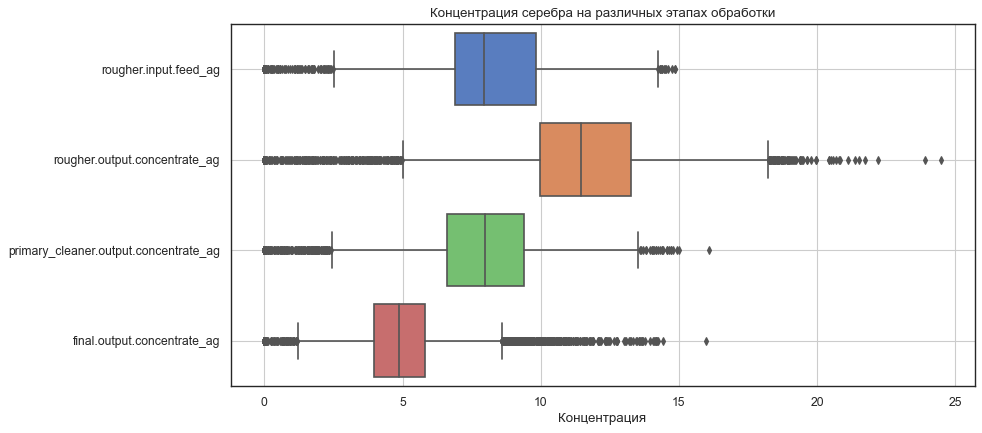

In [24]:
get_hist(gold_recovery_train, concentrate_ag, 'серебра')

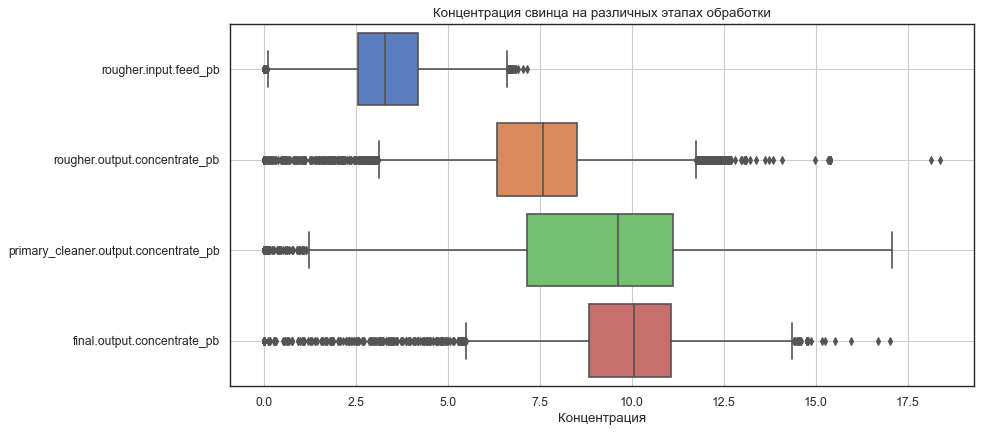

In [25]:
get_hist(gold_recovery_train, concentrate_pb, 'свинца')

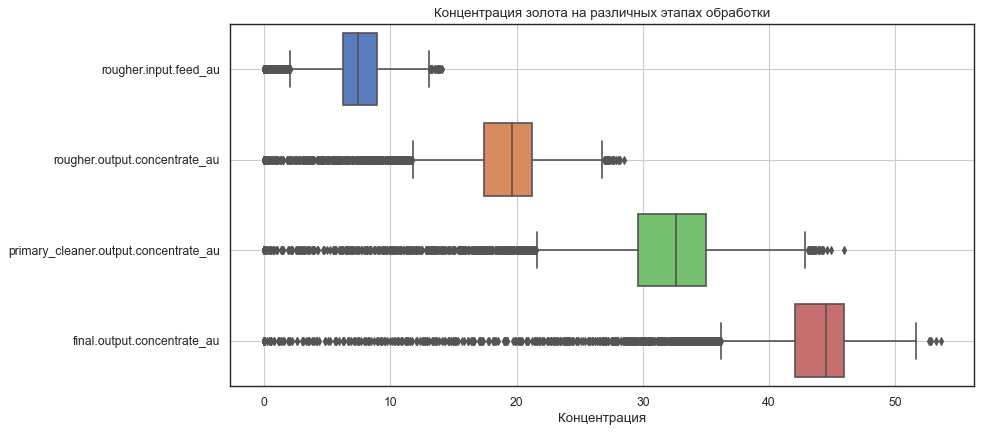

In [26]:
get_hist(gold_recovery_train, concentrate_au, 'золота')

**Вывод:**

По графикам хорошо видно, как поэтапно уменьшается среднее значение концентрации ***серебра(Ag)*** в сырье и увеличивается концентрация ***золота(Au)***.
Среднее значение концентрации ***свинца(Pb)*** также увеличивается.

## <a id='2_2'> 2.2 Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках.</a> 

In [27]:
for column in gold_recovery_train.columns:
    if 'feed_size' in column:
        print (column)

primary_cleaner.input.feed_size
rougher.input.feed_size


Информация о резмере гранул сырья содержится в столбцах `primary_cleaner.input.feed_size` и `rougher.input.feed_size`

In [28]:
def hist_plot(column, stage):
    train = gold_recovery_train[column].dropna()
    test = gold_recovery_test[column].dropna()
    mean_train = np.mean(train)
    var_train = np.var(train)
    std_train = np.sqrt(var_train)
    mean_test = np.mean(test)
    var_test = np.var(test)
    std_test = np.sqrt(var_test)
    
    sns.set(style="white", palette="muted", color_codes=True)
    
    f, ax = plt.subplots(figsize=(8, 8), dpi= 80)
    plt.title('Распределение размеров гранул сырья на этапе '+stage)
    sns.distplot(train, label="Train", 
                 hist_kws={'density':False}, kde_kws={'linewidth':1})
    sns.distplot(test, label="Test", 
                 hist_kws={'density':False}, kde_kws={'linewidth':1})
    
    plt.legend()
    plt.show()
    
    print('Среднее значение в обучающей выборке:', mean_train)
    print('Стандартное отклонение в обучающей выборке:', std_train)
    print('Среднее значение в тестовой выборке:', mean_test)
    print('Стандартное отклонение в тестовой выборке:', std_test)

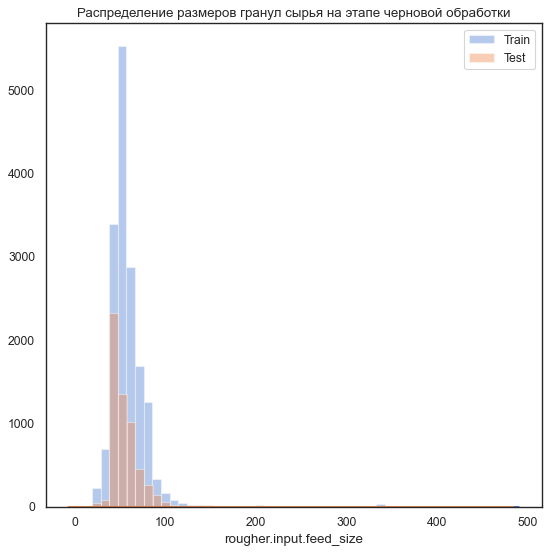

Среднее значение в обучающей выборке: 58.67644376412437
Стандартное отклонение в обучающей выборке: 23.921863317984805
Среднее значение в тестовой выборке: 55.93753506406798
Стандартное отклонение в тестовой выборке: 22.72230614049458


In [29]:
hist_plot('rougher.input.feed_size', 'черновой обработки')

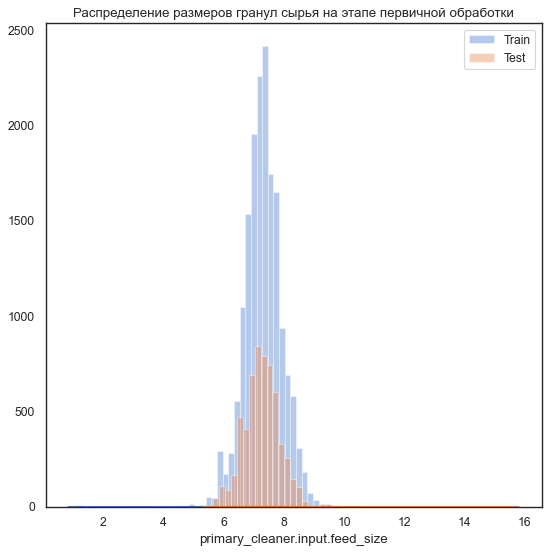

Среднее значение в обучающей выборке: 7.29728487125721
Стандартное отклонение в обучающей выборке: 0.6191473986007594
Среднее значение в тестовой выборке: 7.264651292245429
Стандартное отклонение в тестовой выборке: 0.6114735639413534


In [30]:
hist_plot('primary_cleaner.input.feed_size', 'первичной обработки')

Воспользуемся критерием согласия Колмогорова-Смирнова для оценки распределения размера гранул в обучающей и тестовой выборки.
Пусть нулевая гипотеза гласит что что две исследуемые выборки подчиняются одному распределению случайной величины. Тогда альтернативная гипотеза будет будет гласить что они не подчиняются одному распределению.

In [31]:
def get_ks_statistic(column, alpha=.01):
    train = gold_recovery_train[column].dropna()
    test = gold_recovery_test[column].dropna() 
    results = st.ks_2samp(train, test)

    print('p-значение:', results.pvalue)
    
    if (results.pvalue < alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

In [32]:
print('Для значений среднего распределения размера гранул на этапе черновой обработки:')
get_ks_statistic('rougher.input.feed_size', alpha=.05)

Для значений среднего распределения размера гранул на этапе черновой обработки:
p-значение: 5.871332318176002e-140
Отвергаем нулевую гипотезу


In [33]:
print('Для значений среднего распределения размера гранул на этапе первичной обработки:')
get_ks_statistic('primary_cleaner.input.feed_size', alpha=.05)

Для значений среднего распределения размера гранул на этапе первичной обработки:
p-значение: 1.20224761832344e-10
Отвергаем нулевую гипотезу


**Вывод:**

Распределения размеров гранул сырья на обучающей и тестовой выборках отличаются на черновом этапе обработки и на этапе первичной очистки.

## <a id='2_3'> 2.3 Исследование суммарной концентрацию всех веществ на разных стадиях</a> 

Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.
Рассмотрим эти параметры из общей выборки **gold_recovery_full**. Данные содержатся в столбцах:
`rougher.input.feed_`
`rougher.output.concentrate_`
`final.output.concentrate_` для каждого металла

In [34]:
gold_recovery_full = gold_recovery_full.dropna(subset=['final.output.recovery', 'rougher.output.recovery'])
gold_recovery_full = gold_recovery_full.fillna(method='ffill')

In [35]:
total_concentrate = gold_recovery_full.loc[:, (concentrate_ag+concentrate_au+concentrate_pb)]

In [36]:
def get_sum(stage):
    total_concentrate['total_'+stage] = (total_concentrate[stage+'_ag']+
                                       total_concentrate[stage+'_au']+
                                       total_concentrate[stage+'_pb'])

In [37]:
stages = ['rougher.input.feed', 'rougher.output.concentrate', 'final.output.concentrate']
for stage in stages:
    get_sum(stage)

In [38]:
total_concentrate.head(3)

,rougher.input.feed_ag,rougher.output.concentrate_ag,primary_cleaner.output.concentrate_ag,final.output.concentrate_ag,rougher.input.feed_au,rougher.output.concentrate_au,primary_cleaner.output.concentrate_au,final.output.concentrate_au,rougher.input.feed_pb,rougher.output.concentrate_pb,primary_cleaner.output.concentrate_pb,final.output.concentrate_pb,total_rougher.input.feed,total_rougher.output.concentrate,total_final.output.concentrate
date,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.100378,11.500771,8.547551,6.055403,6.486150,19.793808,34.174427,42.192020,2.284912,7.101074,10.389648,9.889648,14.871440,38.395653,58.137072
2016-01-15 01:00:00,6.161113,11.615865,8.558743,6.029369,6.478583,20.050975,34.118526,42.701629,2.266033,7.278807,10.497069,9.968944,14.905729,38.945647,58.699942
2016-01-15 02:00:00,6.116455,11.695753,8.603505,6.055926,6.362222,19.737170,33.969464,42.657501,2.159622,7.216833,10.354494,10.213995,14.638299,38.649756,58.927421


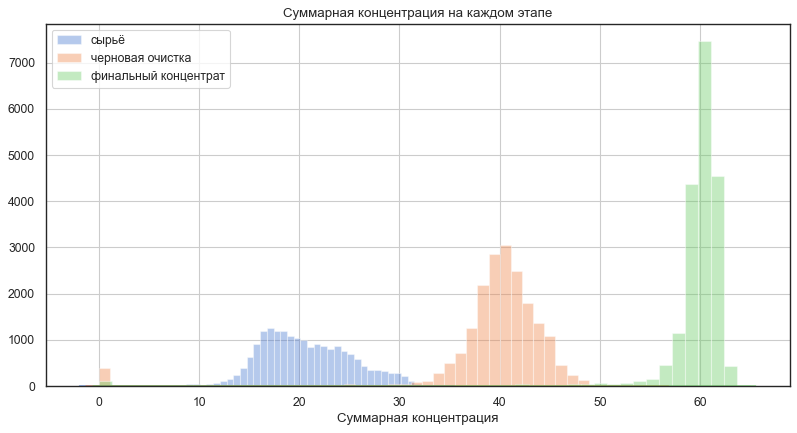

In [39]:
sns.set(style="white", palette="muted", color_codes=True)
f, ax = plt.subplots(figsize=(12, 6), dpi= 80)
plt.title('Суммарная концентрация на каждом этапе')
sns.distplot(total_concentrate['total_rougher.input.feed'], label='сырьё', 
             hist_kws={'density':False}, kde_kws={'linewidth':1})
sns.distplot(total_concentrate['total_rougher.output.concentrate'], label='черновая очистка', 
             hist_kws={'density':False}, kde_kws={'linewidth':1})
sns.distplot(total_concentrate['total_final.output.concentrate'], label='финальный концентрат', 
             hist_kws={'density':False}, kde_kws={'linewidth':1})
ax.set_xlabel('Суммарная концентрация')
ax.grid(True)
plt.legend()
plt.show()

**Вывод:**

По графику видно, что на двух их трёх этапах присутствуют нулевые значения суммарной концентрации металлов. Такие данные могут быть ошибочными, или не информативными. Удалим их из обеих выборок.

In [40]:
total_concentrate_filter = total_concentrate.loc[total_concentrate['total_rougher.input.feed']!= 0]
total_concentrate_filter = total_concentrate_filter.loc[total_concentrate_filter['total_rougher.output.concentrate']!= 0] 
total_concentrate_filter = total_concentrate_filter.loc[total_concentrate_filter['total_final.output.concentrate']!= 0]
print('Размер выборки до удаления', total_concentrate.shape)
print('Размер выборки после удаления', total_concentrate_filter.shape)

Размер выборки до удаления (19439, 15)
Размер выборки после удаления (18949, 15)


Удалим выбросы (Q3+3IQR) из этих данных.

In [41]:
def remove_outlier(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    data = data.loc[data[column] <= (Q3 + 3*IQR)]
    data = data.loc[data[column] >= (Q1 - 3*IQR)]

In [42]:
remove_outlier(total_concentrate_filter, 'total_rougher.input.feed')
remove_outlier(total_concentrate_filter, 'total_rougher.output.concentrate')
remove_outlier(total_concentrate_filter, 'total_final.output.concentrate')
print('Размер выборки после удаления выбросов', total_concentrate_filter.shape)

Размер выборки после удаления выбросов (18949, 15)


In [43]:
train_index=(list(set(total_concentrate_filter.index).intersection(set(train_select_feature.index))))
test_index=(list(set(total_concentrate_filter.index).intersection(set(gold_recovery_test.index))))

In [44]:
train_gold_data = train_select_feature.loc[train_index,:]
test_feature = gold_recovery_test.loc[test_index,:]

In [45]:
print('Размер обучающей выборки до удаления', train_select_feature.shape)
print('Размер обучающей выборки после удаления', train_gold_data.shape)
print()
print('Размер тестовой выборки до удаления', gold_recovery_test.shape)
print('Размер тестовой выборки после удаления', test_feature.shape)

Размер обучающей выборки до удаления (14149, 54)
Размер обучающей выборки после удаления (13795, 54)

Размер тестовой выборки до удаления (5856, 52)
Размер тестовой выборки после удаления (5154, 52)


Отдельно выделим целевые признаки для тестовой выборки из общего датасета.

In [46]:
test_target = gold_recovery_full.loc[test_index,['final.output.recovery', 'rougher.output.recovery']]
print('Размер тестовой выборки для целевого признака', test_target.shape)

Размер тестовой выборки для целевого признака (5154, 2)


# <a id='3'> 3. Модель</a> 

## <a id='3_1'> 3.1 Функция для вычисления итоговой sMAPE</a>

In [47]:
def get_smape(y_true, y_pred):
    delt = np.abs(y_true-y_pred)
    summ = (np.abs(y_true)+np.abs(y_pred))/2
    smape = (sum(delt/summ))/len(y_true)
    return smape

## <a id='3_2'> 3.2 Обучение и оценка качества моделей</a>

Разделим обучающую и тестовую выборки на две части, в зависимости от целевого признака:
- признаки для предсказания `rougher.output.recovery`:
    - rougher.input.feed_ag                    
    - rougher.input.feed_pb                         
    - rougher.input.feed_rate                       
    - rougher.input.feed_size                       
    - rougher.input.feed_sol                        
    - rougher.input.feed_au                         
    - rougher.input.floatbank10_sulfate             
    - rougher.input.floatbank10_xanthate            
    - rougher.input.floatbank11_sulfate             
    - rougher.input.floatbank11_xanthate            
    - rougher.state.floatbank10_a_air               
    - rougher.state.floatbank10_a_level             
    - rougher.state.floatbank10_b_air               
    - rougher.state.floatbank10_b_level             
    - rougher.state.floatbank10_c_air               
    - rougher.state.floatbank10_c_level             
    - rougher.state.floatbank10_d_air               
    - rougher.state.floatbank10_d_level             
    - rougher.state.floatbank10_e_air               
    - rougher.state.floatbank10_e_level             
    - rougher.state.floatbank10_f_air               
    - rougher.state.floatbank10_f_level  
- признаки для предсказания `final.output.recovery`:
    - все признаки.

In [48]:
rougher_features = ['rougher.input.feed_ag', 
                    'rougher.input.feed_pb',
                    'rougher.input.feed_rate',
                    'rougher.input.feed_size',
                    'rougher.input.feed_sol',
                    'rougher.input.feed_au',
                    'rougher.input.floatbank10_sulfate',
                    'rougher.input.floatbank10_xanthate',
                    'rougher.input.floatbank11_sulfate',
                    'rougher.input.floatbank11_xanthate',
                    'rougher.state.floatbank10_a_air',
                    'rougher.state.floatbank10_a_level',
                    'rougher.state.floatbank10_b_air',
                    'rougher.state.floatbank10_b_level',
                    'rougher.state.floatbank10_c_air',
                    'rougher.state.floatbank10_c_level',
                    'rougher.state.floatbank10_d_air',
                    'rougher.state.floatbank10_d_level',
                    'rougher.state.floatbank10_e_air',
                    'rougher.state.floatbank10_e_level',
                    'rougher.state.floatbank10_f_air',
                    'rougher.state.floatbank10_f_level'] 

In [49]:
rougher_train_features = train_gold_data.loc[:,rougher_features]
rougher_train_target = train_gold_data.loc[:,'rougher.output.recovery']

final_train_features = train_gold_data.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
final_train_target = train_gold_data.loc[:,'final.output.recovery']

In [50]:
rougher_test_features = test_feature.loc[:,rougher_features]
rougher_test_target = test_target.loc[:,'rougher.output.recovery']

final_test_features = test_feature
final_test_target = test_target.loc[:,'final.output.recovery']

In [51]:
final_test_features = final_test_features.fillna(method='ffill')
rougher_test_features = rougher_test_features.fillna(method='ffill')
#final_test_features = final_test_features.fillna(method='pad')

В качестве моделей используем Линейную регрессию, Случайный лес и Градиентный бустинг. 

Наилучшие параметры подберём с помошью RandomizedSearchCV

In [52]:
#используем в как метрику качества sMAPE
my_scorer = metrics.make_scorer(get_smape, greater_is_better=False, needs_proba=False, needs_threshold=False)

In [53]:
def get_score(model, X_train, y_train, X_valid, y_valid):
    clf = model.fit(X_train, y_train)
    res = cross_val_score(clf, X_train, y_train, scoring=my_scorer, cv=5)

    print('CV_score: {:.2%}'.format(np.mean(res)))


In [54]:
def get_best_params(features, target, model, parameters):

    #Подберём лучшие параметры модели с помощью RandomizedSearchCV
    clf = RandomizedSearchCV(estimator = model,
                             param_distributions = parameters,
                             scoring=my_scorer, cv = 5,
                             random_state = 124)
    search = clf.fit(features, target)
    print('Best Params: ', search.best_params_)

***Найдём лучшие параметры и оценку качества для модели Случайного леса:***

In [55]:
parameters ={'max_depth':np.arange(1, 11), 
             'n_estimators':np.arange(10, 50, 5)}
rand_forest = RandomForestRegressor(random_state=124)
get_best_params(final_train_features, final_train_target, 
                rand_forest, parameters)

In [56]:
parameters ={'max_depth':np.arange(1, 11), 
             'n_estimators':np.arange(10, 50, 5)}
rand_forest = RandomForestRegressor(random_state=124)
get_best_params(rougher_train_features, rougher_train_target, 
                rand_forest, parameters)

***Найдём лучшие параметры и оценку качества для модели Градинтного бустинга:***
- Этап 1. Подбор параметров, отвечающих за сложность модели

In [57]:
parameters = {'max_depth':np.arange(3, 14),
              'subsample':np.arange(0.5, 1, 0.05)
             }
g_boost = GradientBoostingRegressor(n_estimators=10, learning_rate=0.01, n_iter_no_change=10, random_state=124)
get_best_params(final_train_features, final_train_target, 
                g_boost, parameters)

Best Params:  {'subsample': 0.9000000000000004, 'max_depth': 12}


- Этап 2. Отптимизация

In [58]:
parameters = {'learning_rate': np.arange(0.1, 0.5, 0.1),
              'n_estimators':np.arange(50, 100, 10)}
g_boost = GradientBoostingRegressor(subsample=0.9, max_depth=12, random_state=124)
get_best_params(final_train_features, final_train_target, 
                g_boost, parameters)

Best Params:  {'n_estimators': 80, 'learning_rate': 0.1}


In [64]:
print('Оценка качества Линейной регрессии на final:')
get_score(LinearRegression(), final_train_features, final_train_target, final_test_features, final_test_target)

Оценка качества Линейной регрессии на final:
CV_score: -8.15%


In [65]:
print('Оценка качества Линейной регрессии на rougher:')
get_score(LinearRegression(), rougher_train_features, rougher_train_target, 
          rougher_test_features, rougher_test_target)

Оценка качества Линейной регрессии на rougher:
CV_score: -5.15%


In [66]:
print('Оценка качества Случайного леса на final:')
get_score(RandomForestRegressor(n_estimators=15,max_depth=10, random_state=124), 
          final_train_features, final_train_target, final_test_features, final_test_target)

Оценка качества Случайного леса на final:
CV_score: -6.63%


In [67]:
print('Оценка качества Случайного леса на rougher:')
get_score(RandomForestRegressor(n_estimators=15,max_depth=10, random_state=124), 
          rougher_train_features, rougher_train_target, rougher_test_features, rougher_test_target)

Оценка качества Случайного леса на rougher:
CV_score: -3.39%


In [68]:
print('Оценка качества Градиентного бустинга на final:')
get_score(GradientBoostingRegressor(subsample=0.9, max_depth=12, n_estimators=80, learning_rate=0.1, random_state=124), 
          final_train_features, final_train_target, final_test_features, final_test_target)

Оценка качества Градиентного бустинга на final:
CV_score: -5.71%


In [69]:
print('Оценка качества Градиентного бустинга на rougher:')
get_score(GradientBoostingRegressor(subsample=0.9, max_depth=12, n_estimators=80, learning_rate=0.1, random_state=124), 
          rougher_train_features, rougher_train_target, rougher_test_features, rougher_test_target)

Оценка качества Градиентного бустинга на rougher:
CV_score: -2.82%


Лучшее качество на валидационной выборке показывает модель градиентного бустинга:
- 5.71% для признака `final.output.recovery`
- 2.82% для признака `rougher.output.recovery`

Обучим её на тренировочной выборке.

In [70]:
def smape_score(model, X_train, y_train, X_test, y_test):
    clf = model.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    smape = get_smape(y_test, y_pred)
    print('sMAPE: {:.2%}'.format(smape))
    return smape
    

In [75]:
final_smape = smape_score(GradientBoostingRegressor(subsample=0.9, 
                                                    max_depth=12, 
                                                    n_estimators=80, 
                                                    learning_rate=0.1, 
                                                    random_state=124), 
          final_train_features, final_train_target, final_test_features, final_test_target)

sMAPE: 8.34%


In [76]:
rougher_smape = smape_score(GradientBoostingRegressor(subsample=0.9, 
                                                      max_depth=12, 
                                                      n_estimators=80, 
                                                      learning_rate=0.1, 
                                                      random_state=124), 
          rougher_train_features, rougher_train_target, rougher_test_features, rougher_test_target)

sMAPE: 4.79%


In [77]:
total_smape = 0.25*rougher_smape + 0.75*final_smape
print('Итоговая оценка качества модели GradientBoostingRegressor на тестовой выборке: {:.2%}'.format(total_smape))

Итоговая оценка качества модели GradientBoostingRegressor на тестовой выборке: 7.45%


Сравним качество модели со случайной.

In [71]:
dummy_final_smape = smape_score(DummyRegressor(strategy="mean"), 
          final_train_features, final_train_target, final_test_features, final_test_target)

sMAPE: 8.56%


In [72]:
dummy_rougher_smape = smape_score(DummyRegressor(strategy="mean"), 
          rougher_train_features, rougher_train_target, rougher_test_features, rougher_test_target)

sMAPE: 5.38%


In [74]:
total_smape_dummy = 0.25*dummy_rougher_smape + 0.75*dummy_final_smape
print('Итоговая оценка качества Dummy модели: {:.2%}'.format(total_smape_dummy))

Итоговая оценка качества Dummy модели: 7.77%


**Вывод:**
Построеная нами модель предсказывает концентрацию золота после черновой обработки с качеством sMAPE: **4.79%** и финальную концентрацию после всех этапов очистки с sMAPE: **8.34%**.

Финальное качество модели с учётом обоих показателей **7.45%**, что на 0.32% больше чем у случайной модели.